In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd

from tqdm import tqdm
import requests

import copy
import os

from PIL import Image
import re

import matplotlib.pyplot as plt
from scipy.io import loadmat

import shutil

import osmnx as ox

### data

In [ ]:
# try which_result=1 or =2 to get polygon boundary or only a centeral point
# network_type will simplify the network

cf = '["cycleway"]'
# G = ox.graph_from_place(place, custom_filter=cf)

G = ox.graph_from_place('amsterdam, netherlands',  custom_filter=cf)

G_projected = ox.project_graph(G) # defalut, epsg:4326, uncomment to use local projection crs, e.g., epsg:32630
# ox.plot_graph(G)

# ox.save_graph_shapefile(G, filepath= 'amsterdam')

# gdf = gpd.read_file('./data/stockholm/edges/edges.shp')

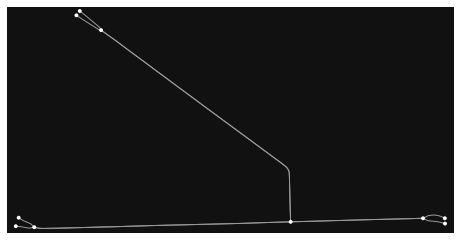

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [ ]:
ox.plot_graph(G)

In [ ]:
### building footprint and height
data = gpd.read_file("../amsterdam/data/BAG/amsterdam_building_age.geojson")

In [ ]:
data

gid building_date  \
0       6371685    1979-01-01   
1       6372800    1954-01-01   
2       6373986    1984-01-01   
3       6377153    1968-01-01   
4       6377575    1958-01-01   
...         ...           ...   
182732  6660535    2019-01-01   
182733  6662058    2017-01-01   
182734  6662853    2011-01-01   
182735  6663374    2018-01-01   
182736  6664684    2017-01-01   

                                                 geometry  
0       POLYGON Z ((4.86944 52.36541 0.00000, 4.86927 ...  
1       POLYGON Z ((4.82779 52.37657 0.00000, 4.82778 ...  
2       POLYGON Z ((4.99067 52.29568 0.00000, 4.99062 ...  
3       POLYGON Z ((4.88861 52.33261 0.00000, 4.88854 ...  
4       POLYGON Z ((4.87722 52.41729 0.00000, 4.87717 ...  
...                                                   ...  
182732  POLYGON Z ((4.93293 52.40507 0.00000, 4.93291 ...  
182733  POLYGON Z ((4.93355 52.34888 0.00000, 4.93355 ...  
182734  POLYGON Z ((4.90476 52.41808 0.00000, 4.90482 ...  
182735  POLYGON Z ((4.95856 52.35425 0.00000, 4.95851 ...  
182736  POLYGON Z ((4.82858 52.36171 0.00000, 4.82862 ...  

[182737 rows x 3 columns]

In [ ]:
### urban street network


### get request point

In [1]:
streets = gpd.read_file("amsStreetSegment.geojson")
streets.head()

NameError: ignored

In [ ]:
np.mean(streets.geometry.iloc[0].xy[0])

4.88784635

In [ ]:
streets.geometry.iloc[0].xy

(array('d', [4.8877742, 4.8879185]), array('d', [52.3702155, 52.370203]))

In [ ]:
def getMidx(g):
    return np.mean(g.xy[0])
def getMidy(g):
    return np.mean(g.xy[1])

In [ ]:
streets['lon'] = streets.geometry.apply(getMidx)
streets['lat'] = streets.geometry.apply(getMidy)

In [ ]:
streets.head(5)

id      angle                                         geometry       lon  \
0  0  94.950893  LINESTRING (4.88777 52.37022, 4.88792 52.37020)  4.887846   
1  1  93.533892  LINESTRING (4.88792 52.37020, 4.88827 52.37018)  4.888095   
2  2  93.994106  LINESTRING (4.88827 52.37018, 4.88840 52.37017)  4.888334   
3  3  10.780887  LINESTRING (4.88840 52.37017, 4.88873 52.37195)  4.888565   
4  4  15.977253  LINESTRING (4.88873 52.37195, 4.88880 52.37219)  4.888768   

         lat  
0  52.370209  
1  52.370192  
2  52.370177  
3  52.371060  
4  52.372067

In [ ]:
streets.shape

(67320, 5)

In [ ]:
streets.to_pickle("streetPt.p", protocol=3)

`python /home/maoransu/software/GSV/GSVdownload_maoran.py /home/maoransu/projects/shadeStreet/streetPt.p -o /home/maoransu/projects/shadeStreet/data -p -t 20 -s 0`

### get panoID

In [ ]:
# Starting from this step, you will need to feed your GSV API key in order to make requests to GSV server. In the line below, please replace 'xxx' with your own key
apiKey = ''

In [ ]:
def GSV_meta_single(lat, lon, apiKey):
    """
    This function obtains GSV metadata at one single request point
    input: latitude and longitude of the request point, api key of your Google Cloud account
    output: dictionary with time, latitude, longitude and panoID of the GSV at the request point
    """
    # original request url for API call
    meta_url = "https://maps.googleapis.com/maps/api/streetview/metadata?size=600x400&location={},{}&key={}"
    # format the request url with feeded parameters
    request_url = meta_url.format(lat, lon, apiKey)
    try:
        # request and format the metadata
        response = requests.get(request_url).json()
        # return metadata if GSV exists
        return {'date':response['date'], 'lat':response['location']['lat'], 'lon':response['location']['lng'], 'panoID':response['pano_id']}
    except:
        # if no GSV is found or any other error happens, return None
        return None

In [ ]:
# construct a list to store all information
metas = []
# iterate over requestPoint DataFrame and request GSV metadata
for i, row in tqdm(streets.iterrows()):
    # obtain metadata for each point
    meta = GSV_meta_single(row['midY'], row['midX'], apiKey)
    # if GSV meta data is successfully downloaded and formatted, save the information
    if meta != None:
        metas.append(meta)
    # time.sleep(0.1)

# convert stored information to DataFrame
panoidDF = pd.DataFrame(metas, columns=['date', 'lat', 'lon', 'panoID'])

9it [00:04,  1.81it/s]


KeyboardInterrupt: 

In [ ]:
panoID = pd.read_pickle("data/ams_panoID.p")

In [ ]:
panoID

panoid        lat       lon    year  month     id
0       wp726FeZKpOw5l48IVpPzQ  52.370240  4.887897  2021.0    7.0      0
1       V0wX7p0DxodSzjg7ZXyaIA  52.370213  4.887881  2020.0    6.0      0
2       wMSIkG-SAW_ecWxJ_Kow5w  52.370211  4.887894  2018.0    6.0      0
3       YiZNyl7nghAPKglRcoRiZw  52.370238  4.887792  2016.0    8.0      0
4       _3iYj9MtuyfwFaszKH4HvQ  52.370211  4.887850  2015.0    6.0      0
...                        ...        ...       ...     ...    ...    ...
595240  rSnpCOdmB0wiuI-8dG3yEA  52.358903  4.891058  2022.0    7.0  67319
595241  8P3ec6bPmEWuqxOs_36G0g  52.358888  4.891088  2020.0   10.0  67319
595242  EYuOUggzlRXvRajVWdgNFA  52.358890  4.891090  2019.0    7.0  67319
595243  GDCtNC7k3CIHWcP-pFd7uA  52.358905  4.891108  2021.0    8.0  67319
595244  O5e-tjP-fp5im08W-4H1aA  52.358885  4.891058  2015.0    6.0  67319

[595245 rows x 6 columns]

In [ ]:
panoID = panoID[panoID.month.isin([6,7,8,9])].drop_duplicates(['id'])

In [ ]:
display(panoID.head())
display(streets.head())

panoid        lat       lon    year  month id
0   wp726FeZKpOw5l48IVpPzQ  52.370240  4.887897  2021.0    7.0  0
12  _3qwo4mzLp1sgC4hQZtmzg  52.370156  4.888123  2021.0    7.0  1
17  oS-Wopwb9Y4y1G-oSLwlwQ  52.370138  4.888264  2021.0    7.0  2
23  jM7NUWjzCYCEhg_obb6Iiw  52.371072  4.888558  2021.0    9.0  3
36  9_LEgygXKSDoorAVb8vgNw  52.372107  4.888758  2021.0    9.0  4

id      angle                                         geometry       lon  \
0  0  94.950893  LINESTRING (4.88777 52.37022, 4.88792 52.37020)  4.887846   
1  1  93.533892  LINESTRING (4.88792 52.37020, 4.88827 52.37018)  4.888095   
2  2  93.994106  LINESTRING (4.88827 52.37018, 4.88840 52.37017)  4.888334   
3  3  10.780887  LINESTRING (4.88840 52.37017, 4.88873 52.37195)  4.888565   
4  4  15.977253  LINESTRING (4.88873 52.37195, 4.88880 52.37219)  4.888768   

         lat  
0  52.370209  
1  52.370192  
2  52.370177  
3  52.371060  
4  52.372067

In [ ]:
panos = panoID.merge(streets[['id','angle']], on='id')

In [ ]:
panos.head()

panoid        lat       lon    year  month id      angle
0  wp726FeZKpOw5l48IVpPzQ  52.370240  4.887897  2021.0    7.0  0  94.950893
1  _3qwo4mzLp1sgC4hQZtmzg  52.370156  4.888123  2021.0    7.0  1  93.533892
2  oS-Wopwb9Y4y1G-oSLwlwQ  52.370138  4.888264  2021.0    7.0  2  93.994106
3  jM7NUWjzCYCEhg_obb6Iiw  52.371072  4.888558  2021.0    9.0  3  10.780887
4  9_LEgygXKSDoorAVb8vgNw  52.372107  4.888758  2021.0    9.0  4  15.977253

In [ ]:
panos['angle'] = panos['angle'].apply(lambda x:(x+90)%360)

In [ ]:
panos.head()

panoid        lat       lon    year  month id       angle
0  wp726FeZKpOw5l48IVpPzQ  52.370240  4.887897  2021.0    7.0  0  184.950893
1  _3qwo4mzLp1sgC4hQZtmzg  52.370156  4.888123  2021.0    7.0  1  183.533892
2  oS-Wopwb9Y4y1G-oSLwlwQ  52.370138  4.888264  2021.0    7.0  2  183.994106
3  jM7NUWjzCYCEhg_obb6Iiw  52.371072  4.888558  2021.0    9.0  3  100.780887
4  9_LEgygXKSDoorAVb8vgNw  52.372107  4.888758  2021.0    9.0  4  105.977253

In [ ]:
panos_other = copy.deepcopy(panos)

In [ ]:
panos_other['angle'] = panos_other['angle'].apply(lambda x:(x+180)%360)

In [ ]:
panos = pd.concat([panos, panos_other])

In [ ]:
panos

panoid        lat       lon    year  month     id  \
0      wp726FeZKpOw5l48IVpPzQ  52.370240  4.887897  2021.0    7.0      0   
1      _3qwo4mzLp1sgC4hQZtmzg  52.370156  4.888123  2021.0    7.0      1   
2      oS-Wopwb9Y4y1G-oSLwlwQ  52.370138  4.888264  2021.0    7.0      2   
3      jM7NUWjzCYCEhg_obb6Iiw  52.371072  4.888558  2021.0    9.0      3   
4      9_LEgygXKSDoorAVb8vgNw  52.372107  4.888758  2021.0    9.0      4   
...                       ...        ...       ...     ...    ...    ...   
65947  2aj0ZQFs19UnYWDoLSELcg  52.358925  4.890940  2021.0    8.0  67315   
65948  2aj0ZQFs19UnYWDoLSELcg  52.358925  4.890940  2021.0    8.0  67316   
65949  S4fsxpCvp1mo8F94lgtYnw  52.358908  4.891118  2021.0    9.0  67317   
65950  S4fsxpCvp1mo8F94lgtYnw  52.358908  4.891118  2021.0    9.0  67318   
65951  S4fsxpCvp1mo8F94lgtYnw  52.358908  4.891118  2021.0    9.0  67319   

            angle  
0      184.950893  
1      183.533892  
2      183.994106  
3      100.780887  
4      105.977253  
...           ...  
65947    4.864514  
65948  359.534191  
65949  353.796552  
65950  353.820076  
65951  346.537739  

[131904 rows x 7 columns]

In [ ]:
panos = panos.rename(columns={'angle':'heading'})

In [ ]:
panos.head(2)

panoid        lat       lon    year  month id     heading
0  wp726FeZKpOw5l48IVpPzQ  52.370240  4.887897  2021.0    7.0  0  184.950893
1  _3qwo4mzLp1sgC4hQZtmzg  52.370156  4.888123  2021.0    7.0  1  183.533892

In [ ]:
panos.to_pickle("data/forImg.p", protocol=3)

### download image

`python /home/maoransu/software/GSV/GSVdownload_maoran.py /home/maoransu/projects/shadeStreet/data/forImg.p -o /media/data_16T/maoransu/projects/shadeStreet/img -g -t 5 -s 0 -n 30 -i panoid --mode heading`

**get downloaded images info**

In [ ]:
imgNames = os.listdir('/media/data_16T/maoransu/projects/shadeStreet/img')

In [ ]:
gsvs = pd.DataFrame([sorted(imgNames), np.arange(len(imgNames))]).T.rename(columns={0:'name', 1:'id'})

In [ ]:
gsvs['panoid'] = gsvs['name'].apply(lambda x:re.split(r'_\d+.jpg', x)[0])

In [ ]:
gsvs['path'] = gsvs['name'].apply(lambda x:os.path.join('/media/data_16T/maoransu/projects/shadeStreet/img', x))

In [ ]:
gsvs.to_pickle("data/forSeg.p", protocol=3)

In [ ]:
sorted(imgNames)

['--0Sm1uRUd7hK3lXFXfY9g_0.jpg',
 '--0Sm1uRUd7hK3lXFXfY9g_180.jpg',
 '--0Sm1uRUd7hK3lXFXfY9g_270.jpg',
 '--0Sm1uRUd7hK3lXFXfY9g_90.jpg',
 '--7J9KpDfyOr9hzRzoFD0Q_0.jpg',
 '--7J9KpDfyOr9hzRzoFD0Q_180.jpg',
 '--7J9KpDfyOr9hzRzoFD0Q_270.jpg',
 '--7J9KpDfyOr9hzRzoFD0Q_90.jpg',
 '--7fHNjsyw_4W1qkYxRS6g_0.jpg',
 '--7fHNjsyw_4W1qkYxRS6g_180.jpg',
 '--7fHNjsyw_4W1qkYxRS6g_270.jpg',
 '--7fHNjsyw_4W1qkYxRS6g_90.jpg',
 '--F9usey6Gn2XlBhTILReA_0.jpg',
 '--F9usey6Gn2XlBhTILReA_180.jpg',
 '--F9usey6Gn2XlBhTILReA_270.jpg',
 '--F9usey6Gn2XlBhTILReA_90.jpg',
 '--InxFlgz52I6bFwaHfiUw_0.jpg',
 '--InxFlgz52I6bFwaHfiUw_180.jpg',
 '--InxFlgz52I6bFwaHfiUw_270.jpg',
 '--InxFlgz52I6bFwaHfiUw_90.jpg',
 '--XVSC2tmBhnw_zvfKQWhg_0.jpg',
 '--XVSC2tmBhnw_zvfKQWhg_180.jpg',
 '--XVSC2tmBhnw_zvfKQWhg_270.jpg',
 '--XVSC2tmBhnw_zvfKQWhg_90.jpg',
 '--_Rzw9QyNUEIV3Hxd4N6A_0.jpg',
 '--_Rzw9QyNUEIV3Hxd4N6A_180.jpg',
 '--_Rzw9QyNUEIV3Hxd4N6A_270.jpg',
 '--_Rzw9QyNUEIV3Hxd4N6A_90.jpg',
 '--g8iXgrqc__PzrVTAXdeA_0.jpg',
 '--g8iX

In [ ]:
sorted(imgNames)

['-79TjuLjW6kIUiLl6cV-xQ_0.jpg',
 '-79TjuLjW6kIUiLl6cV-xQ_180.jpg',
 '-79TjuLjW6kIUiLl6cV-xQ_270.jpg',
 '-79TjuLjW6kIUiLl6cV-xQ_90.jpg',
 '-7IXtCgfn-BYIB1Tp4hOnw_0.jpg',
 '-7IXtCgfn-BYIB1Tp4hOnw_180.jpg',
 '-7IXtCgfn-BYIB1Tp4hOnw_270.jpg',
 '-7IXtCgfn-BYIB1Tp4hOnw_90.jpg',
 '-BjJh6WkWqYCVuQzmmMLvQ_0.jpg',
 '-BjJh6WkWqYCVuQzmmMLvQ_180.jpg',
 '-BjJh6WkWqYCVuQzmmMLvQ_270.jpg',
 '-BjJh6WkWqYCVuQzmmMLvQ_90.jpg',
 '-IS4Qlj0MsDBLuLSO-ZvLw_0.jpg',
 '-IS4Qlj0MsDBLuLSO-ZvLw_180.jpg',
 '-IS4Qlj0MsDBLuLSO-ZvLw_270.jpg',
 '-IS4Qlj0MsDBLuLSO-ZvLw_90.jpg',
 '-J6jQ6jee-eSO8XXuuB3Qw_0.jpg',
 '-J6jQ6jee-eSO8XXuuB3Qw_180.jpg',
 '-J6jQ6jee-eSO8XXuuB3Qw_270.jpg',
 '-J6jQ6jee-eSO8XXuuB3Qw_90.jpg',
 '-N2XhXoOTQFNMcbsmgIMBg_0.jpg',
 '-N2XhXoOTQFNMcbsmgIMBg_180.jpg',
 '-N2XhXoOTQFNMcbsmgIMBg_270.jpg',
 '-N2XhXoOTQFNMcbsmgIMBg_90.jpg',
 '-O22tbsyIA0DKq75-lHZaw_0.jpg',
 '-O22tbsyIA0DKq75-lHZaw_180.jpg',
 '-O22tbsyIA0DKq75-lHZaw_270.jpg',
 '-O22tbsyIA0DKq75-lHZaw_90.jpg',
 '-POuj04Cc22_Cd2xqYez3g_0.jpg',
 '-POuj0

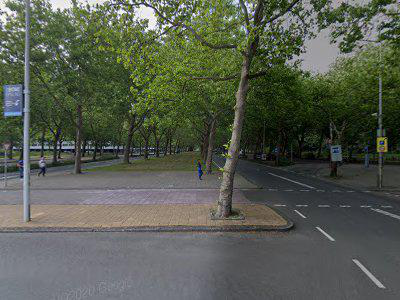

In [ ]:
Image.open(os.path.join("/media/data_16T/maoransu/projects/shadeStreet/img", sorted(imgNames)[0]))

### semantic segmentation

`cd /home/yuanzf/software/semantic-segmentation-pytorch/`

`/home/yuanzf/anaconda3/envs/senseable/bin/python /home/yuanzf/software/semantic-segmentation-pytorch/test.py --test_df /home/maoransu/projects/shadeStreet/data/forSeg.p --cfg ./config/ade20k-resnet18dilated-ppm_deepsup.yaml --gpu 2 --return_label --multiFolders TEST.result /media/data_16T/maoransu/projects/shadeStreet/segmentation`

`python /home/yuanzf/software/semantic-segmentation-pytorch/test.py --test_df /home/maoransu/projects/shadeStreet/data/forSeg.p --cfg ./config/ade20k-resnet18dilated-ppm_deepsup.yaml --gpu 2 --return_label --multiFolders TEST.result /media/data_16T/maoransu/projects/shadeStreet/segmentation`

`python /home/maoransu/utils/dir_traversal.py /media/data_16T/maoransu/projects/shadeStreet/segmentation -o /media/data_16T/maoransu/projects/shadeStreet`

In [ ]:
# get segmentation results
segs = pd.read_pickle("/media/data_16T/maoransu/projects/shadeStreet/imgSegResult.p")

In [ ]:
segs['total_pixel'] = segs.sum(axis=1)

In [ ]:
segs = segs[['sky', 'total_pixel']]
# segs['panoid'] = segs.index.apply(getPanoid)

In [ ]:
def getPanoid(name):
    if name[-3:] in ['270', '180']:
        return name[:-4]
    elif name[-3:] == '_90':
        return name[:-3]
    else:
        return name[:-2]

In [ ]:
segs = segs.reset_index()
segs['panoid'] = segs['index'].apply(getPanoid)

In [ ]:
segs

index      sky  total_pixel  \
0       aWek0OxNqGKJjJ-vvERJJg_270  20658.0     120000.0   
1        w0J_fNlIiCx1z4JejUIQjg_90  20112.0     120000.0   
2       lA-jd24hDVM_KTyOJ-CSvg_180  38532.0     120000.0   
3       iH9nlCS9XCL_miThq0mdQA_180  51750.0     120000.0   
4       BePzoIzPckP_bG3tTdAwmA_180   3638.0     120000.0   
...                            ...      ...          ...   
216563   r7rqdzbhHDFaHUgCxCFyFA_90  38308.0     120000.0   
216564   lGwCifj8HSxD6dbQrurQdw_90  35126.0     120000.0   
216565    lbEpDLucaVcCdIKiF478Uw_0  26503.0     120000.0   
216566   Yw7ki2ZhQfrPPD2G7SporQ_90  22977.0     120000.0   
216567    VIJxrrWenwfJ5XWlBL0xKQ_0  49613.0     120000.0   

                        panoid  
0       aWek0OxNqGKJjJ-vvERJJg  
1       w0J_fNlIiCx1z4JejUIQjg  
2       lA-jd24hDVM_KTyOJ-CSvg  
3       iH9nlCS9XCL_miThq0mdQA  
4       BePzoIzPckP_bG3tTdAwmA  
...                        ...  
216563  r7rqdzbhHDFaHUgCxCFyFA  
216564  lGwCifj8HSxD6dbQrurQdw  
216565  lbEpDLucaVcCdIKiF478Uw  
216566  Yw7ki2ZhQfrPPD2G7SporQ  
216567  VIJxrrWenwfJ5XWlBL0xKQ  

[216568 rows x 4 columns]

In [ ]:
segResult = segs.groupby('panoid').sum().reset_index()
segResult['skyIndex'] = segResult['sky'] / segResult['total_pixel']

In [ ]:
segResult

panoid       sky  total_pixel  skyIndex
0      --0Sm1uRUd7hK3lXFXfY9g  112368.0     480000.0  0.234100
1      --7J9KpDfyOr9hzRzoFD0Q  165356.0     480000.0  0.344492
2      --7fHNjsyw_4W1qkYxRS6g  122487.0     480000.0  0.255181
3      --F9usey6Gn2XlBhTILReA   59306.0     480000.0  0.123554
4      --InxFlgz52I6bFwaHfiUw  142671.0     480000.0  0.297231
...                       ...       ...          ...       ...
54137  zzVIducDECA4n2JpRB-G5A  158628.0     480000.0  0.330475
54138  zz_x6y5R5ALfLXIBl2HJvg  225855.0     480000.0  0.470531
54139  zzf_evtrY6nodTh82N5weg  128125.0     480000.0  0.266927
54140  zzwIMjbaCWxlbV1ZlS13eQ   96691.0     480000.0  0.201440
54141  zzxFUO713lG0gcS2-cOMTw  129757.0     480000.0  0.270327

[54142 rows x 4 columns]

### join sky index to points

In [ ]:
result = panos.merge(segResult[['panoid','skyIndex']], on='panoid')

In [ ]:
result = result.drop_duplicates('id').reset_index(drop=True)

In [ ]:
result.head()

panoid        lat       lon    year  month id     heading  \
0  wp726FeZKpOw5l48IVpPzQ  52.370240  4.887897  2021.0    7.0  0  184.950893   
1  _3qwo4mzLp1sgC4hQZtmzg  52.370156  4.888123  2021.0    7.0  1  183.533892   
2  oS-Wopwb9Y4y1G-oSLwlwQ  52.370138  4.888264  2021.0    7.0  2  183.994106   
3  jM7NUWjzCYCEhg_obb6Iiw  52.371072  4.888558  2021.0    9.0  3  100.780887   
4  9_LEgygXKSDoorAVb8vgNw  52.372107  4.888758  2021.0    9.0  4  105.977253   

   skyIndex  
0  0.136465  
1  0.186885  
2  0.160037  
3  0.094654  
4  0.123338

In [ ]:
result.to_csv("skyIndexAMS.csv")

In [ ]:
result[result['skyIndex']<0.15].to_csv("skyIndexAMSselected.csv")

In [ ]:
panos

panoid        lat       lon    year  month     id  \
0      wp726FeZKpOw5l48IVpPzQ  52.370240  4.887897  2021.0    7.0      0   
1      _3qwo4mzLp1sgC4hQZtmzg  52.370156  4.888123  2021.0    7.0      1   
2      oS-Wopwb9Y4y1G-oSLwlwQ  52.370138  4.888264  2021.0    7.0      2   
3      jM7NUWjzCYCEhg_obb6Iiw  52.371072  4.888558  2021.0    9.0      3   
4      9_LEgygXKSDoorAVb8vgNw  52.372107  4.888758  2021.0    9.0      4   
...                       ...        ...       ...     ...    ...    ...   
65947  2aj0ZQFs19UnYWDoLSELcg  52.358925  4.890940  2021.0    8.0  67315   
65948  2aj0ZQFs19UnYWDoLSELcg  52.358925  4.890940  2021.0    8.0  67316   
65949  S4fsxpCvp1mo8F94lgtYnw  52.358908  4.891118  2021.0    9.0  67317   
65950  S4fsxpCvp1mo8F94lgtYnw  52.358908  4.891118  2021.0    9.0  67318   
65951  S4fsxpCvp1mo8F94lgtYnw  52.358908  4.891118  2021.0    9.0  67319   

          heading  
0      184.950893  
1      183.533892  
2      183.994106  
3      100.780887  
4      105.977253  
...           ...  
65947    4.864514  
65948  359.534191  
65949  353.796552  
65950  353.820076  
65951  346.537739  

[131904 rows x 7 columns]

### plot typycal street images

In [ ]:
segFiles = pd.read_pickle("/home/maoransu/projects/shadeStreet/data/forSeg.p")
segFiles.head()

name id                  panoid  \
0    --0Sm1uRUd7hK3lXFXfY9g_0.jpg  0  --0Sm1uRUd7hK3lXFXfY9g   
1  --0Sm1uRUd7hK3lXFXfY9g_180.jpg  1  --0Sm1uRUd7hK3lXFXfY9g   
2  --0Sm1uRUd7hK3lXFXfY9g_270.jpg  2  --0Sm1uRUd7hK3lXFXfY9g   
3   --0Sm1uRUd7hK3lXFXfY9g_90.jpg  3  --0Sm1uRUd7hK3lXFXfY9g   
4    --7J9KpDfyOr9hzRzoFD0Q_0.jpg  4  --7J9KpDfyOr9hzRzoFD0Q   

                                                path  
0  /media/data_16T/maoransu/projects/shadeStreet/...  
1  /media/data_16T/maoransu/projects/shadeStreet/...  
2  /media/data_16T/maoransu/projects/shadeStreet/...  
3  /media/data_16T/maoransu/projects/shadeStreet/...  
4  /media/data_16T/maoransu/projects/shadeStreet/...

In [ ]:
segResultImg = pd.read_pickle("/media/data_16T/maoransu/projects/shadeStreet/segResult.p")
segResultImg['path'] = [os.path.join(f,n) for f,n in zip(segResultImg['folder'], segResultImg['name'])]
segResultImg['panoid'] = segResultImg['name'].apply(lambda x:re.split(r'_\d+.png', x)[0])

In [ ]:
segFiles.path.iloc[0]

'/media/data_16T/maoransu/projects/shadeStreet/img/--0Sm1uRUd7hK3lXFXfY9g_0.jpg'

In [ ]:
result[result.skyIndex<0.1].sample(2).panoid

19787    XuQcx5sSZwTlmTFowD8dzw
13444    7uj_se42A6L6rn8WthXU7A
Name: panoid, dtype: object

In [ ]:
# visualize segmentation
def visualize_result(img, pred, index=None):
    # filter prediction class if requested
    if index is not None:
        pred = pred.copy()
        pred[pred != index] = -1
        print(f'{names[index+1]}:')
        
    # colorize prediction
    pred_color = colorEncode(pred, colors).astype(np.uint8)

    # aggregate images and save
#     im_vis = np.concatenate((img, pred_color), axis=1)
#     display(Image.fromarray(pred_color))
    return Image.fromarray(pred_color)
    
def unique(ar, return_index=False, return_inverse=False, return_counts=False):
    ar = np.asanyarray(ar).flatten()

    optional_indices = return_index or return_inverse
    optional_returns = optional_indices or return_counts

    if ar.size == 0:
        if not optional_returns:
            ret = ar
        else:
            ret = (ar,)
            if return_index:
                ret += (np.empty(0, np.bool),)
            if return_inverse:
                ret += (np.empty(0, np.bool),)
            if return_counts:
                ret += (np.empty(0, np.intp),)
        return ret
    if optional_indices:
        perm = ar.argsort(kind='mergesort' if return_index else 'quicksort')
        aux = ar[perm]
    else:
        ar.sort()
        aux = ar
    flag = np.concatenate(([True], aux[1:] != aux[:-1]))

    if not optional_returns:
        ret = aux[flag]
    else:
        ret = (aux[flag],)
        if return_index:
            ret += (perm[flag],)
        if return_inverse:
            iflag = np.cumsum(flag) - 1
            inv_idx = np.empty(ar.shape, dtype=np.intp)
            inv_idx[perm] = iflag
            ret += (inv_idx,)
        if return_counts:
            idx = np.concatenate(np.nonzero(flag) + ([ar.size],))
            ret += (np.diff(idx),)
    return ret
    
def colorEncode(labelmap, colors, mode='RGB'):
    labelmap = labelmap.astype('int')
    labelmap_rgb = np.zeros((labelmap.shape[0], labelmap.shape[1], 3),
                            dtype=np.uint8)
    for label in unique(labelmap):
        if label < 0:
            continue
        labelmap_rgb += (labelmap == label)[:, :, np.newaxis] * \
            np.tile(colors[label],
                    (labelmap.shape[0], labelmap.shape[1], 1))

    if mode == 'BGR':
        return labelmap_rgb[:, :, ::-1]
    else:
        return labelmap_rgb
    
colors = loadmat('/media/data_16T/maoransu/projects/visual_ai/color150.mat')['colors']

In [ ]:
os.mkdir("selected")

In [ ]:
os.mkdir("selected/raw")
os.mkdir("selected/processed")

In [ ]:
panoids = ['SNRHNyxpgYUQW0BnC1wN0A', 'DFsqfJ36Mpl1FCu_o1OXAg', 's0eLCmAEKREpzYG4k1Ku8w', 
           'sgmXvFSoq6cegf29guw3og', 'MIIv-ARkqJB0hqJ4BCmGmg', 'op1oPg8Au6fsItBpzyneUQ', 
           'nGbD6ph7tasdFEs5L6OQ6A']

for pid in panoids:
    segFile = sorted(segFiles[segFiles.panoid.isin([pid])]['path'])
    segResultFile = sorted(segResultImg[segResultImg.panoid.isin([pid])]['path'])
    for idx in range(len(segFile)):
        rawPath = segFile[idx]
        proPath = segResultFile[idx]
        rawImage = Image.open(rawPath)
        proImage = Image.open(proPath)
        recolorImage = visualize_result(np.array(rawImage), np.array(proImage))
        rawImage.save("selected/raw/{}".format(rawPath.split('/')[-1]))
        recolorImage.save("selected/processed/{}".format(proPath.split('/')[-1]))

SNRHNyxpgYUQW0BnC1wN0A


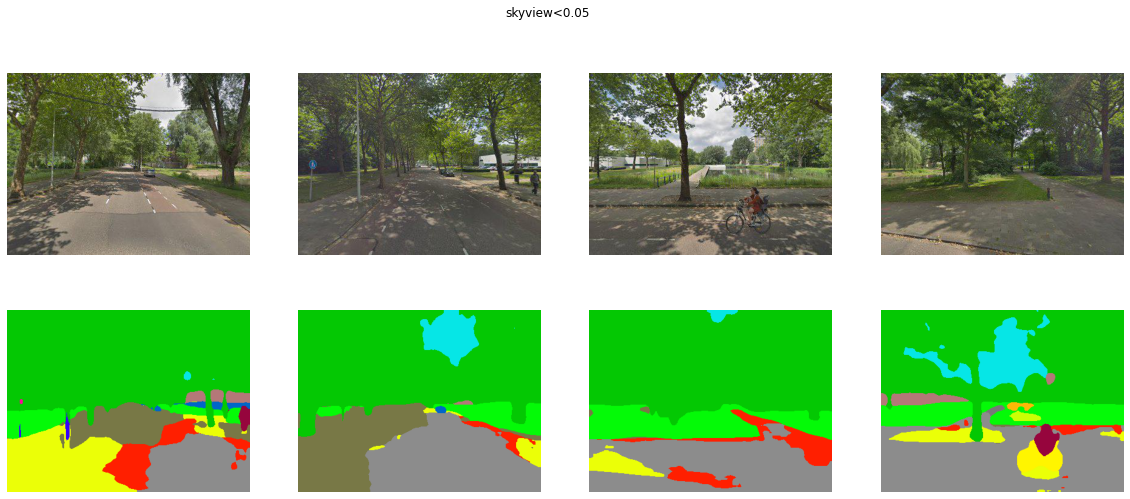

In [ ]:
panoids = result[result.skyIndex<0.05].sample(1).panoid
for p in panoids:
    print(p)
    segFile = sorted(segFiles[segFiles.panoid.isin([p])]['path'])
    segResultFile = sorted(segResultImg[segResultImg.panoid.isin([p])]['path'])
#     display(segResultFile)
    fig, axes = plt.subplots(2,4, figsize=(20,8))
    axes = axes.flatten()
    for idx, imgPath in enumerate(segFile):
        axes[idx].imshow(Image.open(imgPath))
        axes[idx].axis('off')
        axes[idx+4].imshow(visualize_result(np.array(Image.open(imgPath)), np.array(Image.open(segResultFile[idx]))))
        axes[idx+4].axis('off')
    plt.suptitle("skyview<0.05")
    plt.show()

DFsqfJ36Mpl1FCu_o1OXAg


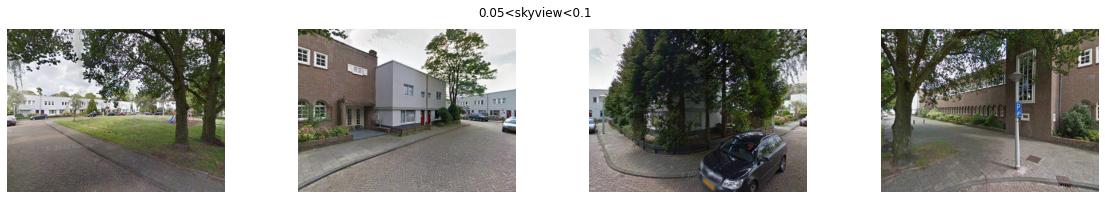

In [ ]:
panoids = result[(result.skyIndex>0.05) & (result.skyIndex<0.1)].sample(1).panoid
for p in panoids:
    print(p)
    segFile = segFiles[segFiles.panoid.isin([p])]['path']
    fig, axes = plt.subplots(1,4, figsize=(20,3))
    for idx, imgPath in enumerate(segFile):
        axes[idx].imshow(Image.open(imgPath))
        axes[idx].axis('off')
    plt.suptitle("0.05<skyview<0.1")
    plt.show()

nGbD6ph7tasdFEs5L6OQ6A


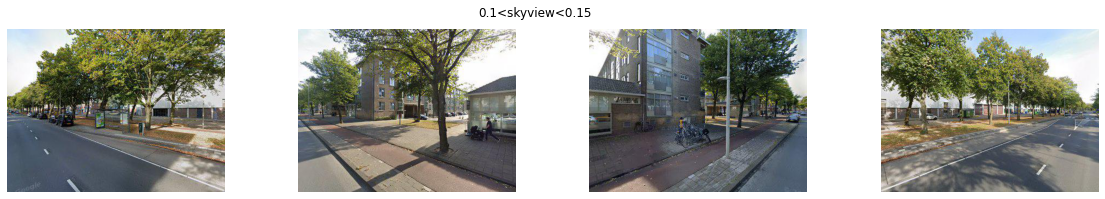

In [ ]:
panoids = result[(result.skyIndex>0.1) & (result.skyIndex<0.15)].sample(1).panoid
for p in panoids:
    print(p)
    segFile = segFiles[segFiles.panoid.isin([p])]['path']
    fig, axes = plt.subplots(1,4, figsize=(20,3))
    for idx, imgPath in enumerate(segFile):
        axes[idx].imshow(Image.open(imgPath))
        axes[idx].axis('off')
    plt.suptitle("0.1<skyview<0.15")
    plt.show()

op1oPg8Au6fsItBpzyneUQ


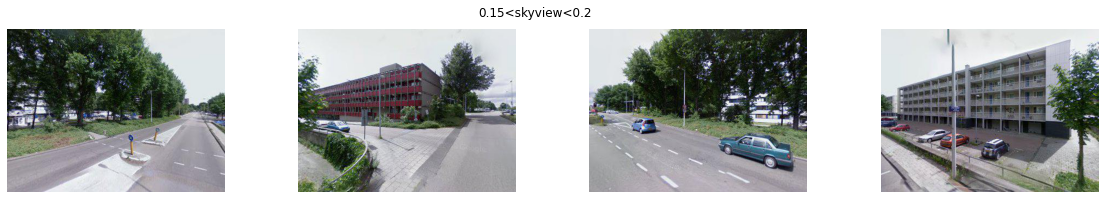

In [ ]:
panoids = result[(result.skyIndex>0.15) & (result.skyIndex<0.2)].sample(1).panoid
for p in panoids:
    print(p)
    segFile = segFiles[segFiles.panoid.isin([p])]['path']
    fig, axes = plt.subplots(1,4, figsize=(20,3))
    for idx, imgPath in enumerate(segFile):
        axes[idx].imshow(Image.open(imgPath))
        axes[idx].axis('off')
    plt.suptitle("0.15<skyview<0.2")
    plt.show()

MIIv-ARkqJB0hqJ4BCmGmg


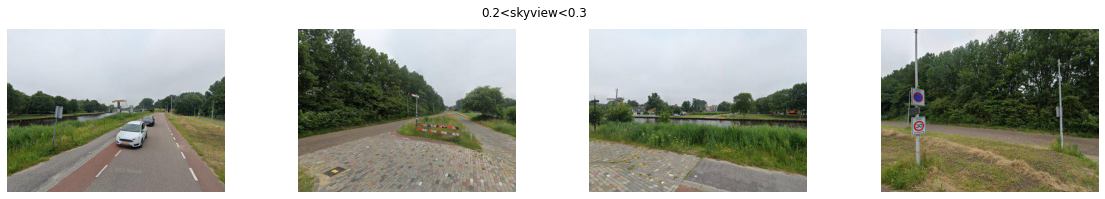

In [ ]:
panoids = result[(result.skyIndex>0.2) & (result.skyIndex<0.3)].sample(1).panoid
for p in panoids:
    print(p)
    segFile = segFiles[segFiles.panoid.isin([p])]['path']
    fig, axes = plt.subplots(1,4, figsize=(20,3))
    for idx, imgPath in enumerate(segFile):
        axes[idx].imshow(Image.open(imgPath))
        axes[idx].axis('off')
    plt.suptitle("0.2<skyview<0.3")
    plt.show()

sgmXvFSoq6cegf29guw3og


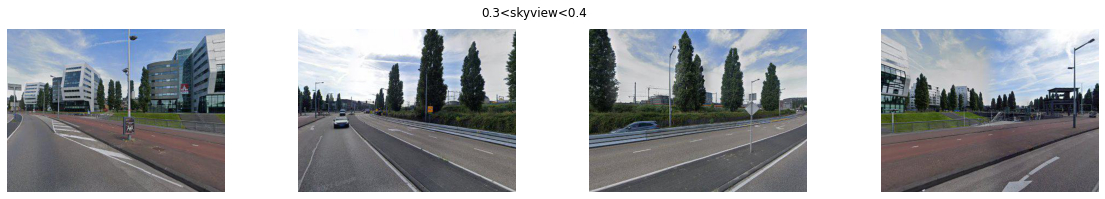

In [ ]:
panoids = result[(result.skyIndex>0.3) & (result.skyIndex<0.4)].sample(1).panoid
for p in panoids:
    print(p)
    segFile = segFiles[segFiles.panoid.isin([p])]['path']
    fig, axes = plt.subplots(1,4, figsize=(20,3))
    for idx, imgPath in enumerate(segFile):
        axes[idx].imshow(Image.open(imgPath))
        axes[idx].axis('off')
    plt.suptitle("0.3<skyview<0.4")
    plt.show()

s0eLCmAEKREpzYG4k1Ku8w


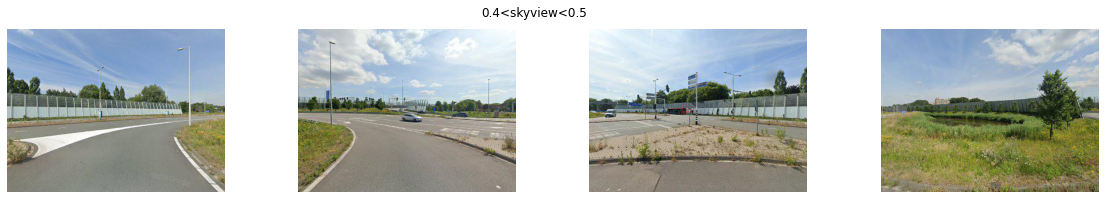

In [ ]:
panoids = result[(result.skyIndex>0.4) & (result.skyIndex<0.5)].sample(1).panoid
for p in panoids:
    print(p)
    segFile = segFiles[segFiles.panoid.isin([p])]['path']
    fig, axes = plt.subplots(1,4, figsize=(20,3))
    for idx, imgPath in enumerate(segFile):
        axes[idx].imshow(Image.open(imgPath))
        axes[idx].axis('off')
    plt.suptitle("0.4<skyview<0.5")
    plt.show()

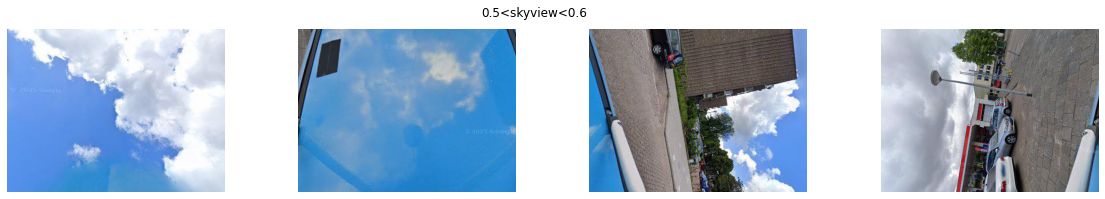

In [ ]:
# panoids = result[(result.skyIndex>0.5) & (result.skyIndex<0.6)].sample(1).panoid
# for p in panoids:
#     segFile = segFiles[segFiles.panoid.isin([p])]['path']
#     fig, axes = plt.subplots(1,4, figsize=(20,3))
#     for idx, imgPath in enumerate(segFile):
#         axes[idx].imshow(Image.open(imgPath))
#         axes[idx].axis('off')
#     plt.suptitle("0.5<skyview<0.6")
#     plt.show()

In [ ]:
# panoids = result[(result.skyIndex>0.6) & (result.skyIndex<0.7)].sample(1).panoid
# for p in panoids:
#     segFile = segFiles[segFiles.panoid.isin([p])]['path']
#     fig, axes = plt.subplots(1,4, figsize=(20,3))
#     for idx, imgPath in enumerate(segFile):
#         axes[idx].imshow(Image.open(imgPath))
#         axes[idx].axis('off')
#     plt.suptitle("0.6<skyview<0.7")
#     plt.show()

In [ ]:
# panoids = result[(result.skyIndex>0.7) & (result.skyIndex<0.8)].sample(1).panoid
# for p in panoids:
#     segFile = segFiles[segFiles.panoid.isin([p])]['path']
#     fig, axes = plt.subplots(1,4, figsize=(20,3))
#     for idx, imgPath in enumerate(segFile):
#         axes[idx].imshow(Image.open(imgPath))
#         axes[idx].axis('off')
#     plt.suptitle("0.7<skyview<0.8")
#     plt.show()

ValueError: a must be greater than 0 unless no samples are taken

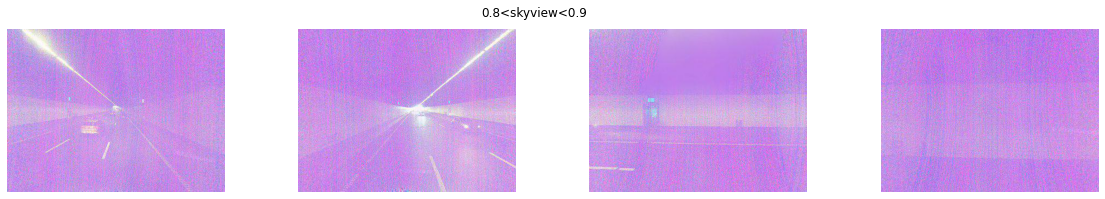

In [ ]:
# panoids = result[(result.skyIndex>0.8) & (result.skyIndex<0.9)].sample(1).panoid
# for p in panoids:
#     segFile = segFiles[segFiles.panoid.isin([p])]['path']
#     fig, axes = plt.subplots(1,4, figsize=(20,3))
#     for idx, imgPath in enumerate(segFile):
#         axes[idx].imshow(Image.open(imgPath))
#         axes[idx].axis('off')
#     plt.suptitle("0.8<skyview<0.9")
#     plt.show()

In [ ]:
# panoids = result[(result.skyIndex>0.9) & (result.skyIndex<1)].sample(1).panoid
# for p in panoids:
#     segFile = segFiles[segFiles.panoid.isin([p])]['path']
#     fig, axes = plt.subplots(1,4, figsize=(20,3))
#     for idx, imgPath in enumerate(segFile):
#         axes[idx].imshow(Image.open(imgPath))
#         axes[idx].axis('off')
#     plt.suptitle("0.9<skyview<1")
#     plt.show()

ValueError: a must be greater than 0 unless no samples are taken

### join point to street

In [ ]:
streets.head(2)

id      angle                                         geometry       lon  \
0  0  94.950893  LINESTRING (4.88777 52.37022, 4.88792 52.37020)  4.887846   
1  1  93.533892  LINESTRING (4.88792 52.37020, 4.88827 52.37018)  4.888095   

         lat  
0  52.370209  
1  52.370192

In [ ]:
result.head(2)

panoid        lat       lon    year  month id     heading  \
0  wp726FeZKpOw5l48IVpPzQ  52.370240  4.887897  2021.0    7.0  0  184.950893   
1  _3qwo4mzLp1sgC4hQZtmzg  52.370156  4.888123  2021.0    7.0  1  183.533892   

   skyIndex  
0  0.136465  
1  0.186885

In [ ]:
streets = streets.merge(result)

In [ ]:
streetResult = streets[['id', 'geometry']].merge(result[['panoid','id', 'skyIndex']], on='id')

In [ ]:
streetResult.to_file("streetSkyIndex.geojson", driver='GeoJSON')